# Source code

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np, h5py, matplotlib.pyplot as plt, pyqtgraph as pg, numba as nb, concurrent.futures, cv2, os
from scipy.ndimage.filters import median_filter, gaussian_filter
from scipy.ndimage.measurements import label, maximum_position, center_of_mass
from scipy import constants
from multiprocessing import cpu_count
from functools import partial
from itertools import accumulate
from math import cos, sin, sqrt, pi, atan2
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from skimage.transform import probabilistic_hough_line
from skimage.draw import line_aa
from cbc import RecLattice
from cbc_dp.utils import MASKS as mask_dict, ORIGINS as zero_dict, rotation_matrix
from cbc_dp.Qt import VolumeViewer, ScatterViewer, make_app, vol_data
from cbc_dp import CorrectedData, LineSegmentDetector, HoughLineDetector, NMS, CircPropagator, SquarePropagator, FrameStreaks, ScanStreaks

In [2]:
class ROI(object):
    def __init__(self, roi):
        self.roi = roi
        
    @property
    def index(self): return (slice(self.roi[0], self.roi[1]), slice(self.roi[2], self.roi[3]))
    
    def mask(self, shape):
        mask = np.zeros(shape, dtype=np.uint8)
        mask[self.index] = 1
        return mask
    
    def __getitem__(self, index): return self.roi[index]
    
def loadlines(file):
    idxs = list(file[linespath])
    idxs.sort()
    return [file[linespath][idx][:] for idx in idxs]

def loadintensities(file):
    idxs = list(file[intspath])
    idxs.sort()
    return [file[intspath][idx][:] for idx in idxs]

In [3]:
peakspath = "exp_results/scan_{0:05}/scan_peaks_{0:05}.h5"
corpath = "exp_results/scan_{0:05}/scan_corrected_{0:05}.h5"
cordatapath = 'corrected_data/data'
bgdpath = 'corrected_data/background'
cordatapath = 'corrected_data/corrected_data'
strkspath = 'corrected_data/streaks_data'
datapath = 'data/data'
linespath = 'peaks_data/bragg_lines'
intspath = 'peaks_data/bragg_intensities'
pupilroi = ROI(np.array([1070, 1250, 1250, 1600]))
lysroi = ROI(np.array([500, 1767, 800, 2070]))
b12roi = ROI(np.array([700, 2167, 600, 2070]))
b12zero, lyszero = zero_dict[135], zero_dict[107]
fullroi = ROI(np.array([0, 2167, 0, 2070]))
b12dist, lysdist = 182.7, 150.0
pixsize = 75 * 1e-3
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3
rotaxis = [0, 1, 0]
a, b, c = np.array([16.18, 0, 0]) * 1e-7, np.array([0, 21.23, 0]) * 1e-7, np.array([0, 0, 24.33]) * 1e-7

In [ ]:
f135 = h5py.File(corpath.format(135), 'r')
b12data = f135[cordatapath][:]
b12bgd = f135[bgdpath][:]
b12strksdata = f135[strkspath][:]

In [ ]:
f107 = h5py.File(corpath.format(107), 'r')
lysdata = f107[cordatapath][:]
lysbgd = f107[bgdpath][:]
lysstrksdata = f107[strkspath][:]

In [ ]:
f133 = h5py.File(corpath.format(133), 'r')
b12data2 = f133[cordatapath][:]
b12bgd2 = f133[bgdpath][:]
b12strksdata2 = f133[strkspath][:]

# Line detection

In [230]:
image = b12data[90]
image2 = b12data2[0]
strks = b12strksdata[90]
strks2 = b12strksdata2[0]
nms = NMS(strks.astype(np.float64))
houghdet = HoughLineDetector(threshold=15, line_length=15, line_gap=3, dth=np.pi/200)
lsd = LineSegmentDetector()

In [11]:
pg.mkColor((1.0, 1.0, 1.0, 0.5))

In [14]:
np.sum((np.zeros(2), np.ones(2)), axis=0)

array([1., 1.])

In [ ]:
framelns1 = lsd.detectFrame(strks, b12zero, drtau=20, drn=10)
framelns2 = lsd.detectFrame(strks2,)

In [30]:
strkslist = []
strkslist.append(houghdet.detectFrame(strks, b12zero, drtau=20, drn=10))
strkslist.append(houghdet.detectFrame(nms, b12zero, drtau=20, drn=10))
strkslist.append(lsd.detectFrame(strks, b12zero, drtau=20, drn=10))
strkslist.append(lsd.detectFrame(nms, b12zero, drtau=20, drn=10))
ptslist = [strks.indexpoints() for strks in strkslist]

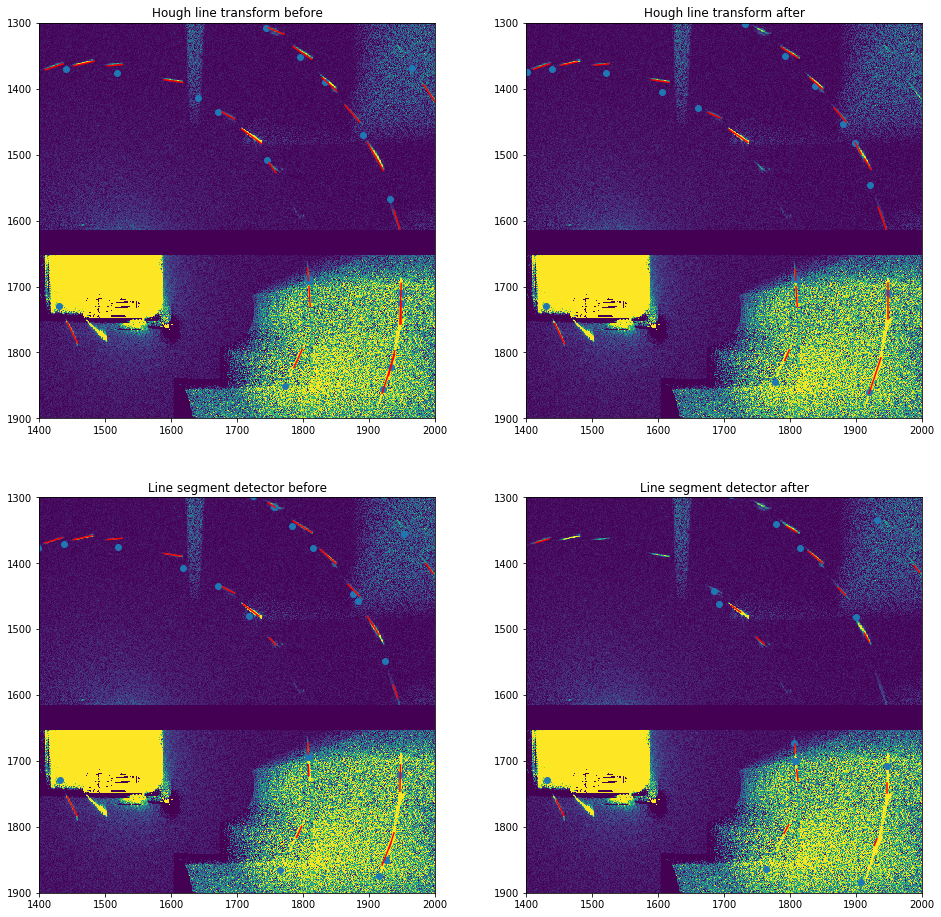

In [32]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
titles = ['Hough line transform before', 'Hough line transform after', 'Line segment detector before', 'Line segment detector after']
for ax, lines, pts, title in zip(axes.ravel(), strkslist, ptslist, titles):
    ax.imshow(image, vmax=200)
    for line in lines:
        ax.plot(line[:, 0], line[:, 1], 'r')  
    ax.scatter(pts[:, 0], pts[:, 1])
    ax.set_xlim(1400, 2000)
    ax.set_ylim(1900, 1300)
    ax.set_title(title)
plt.show()

# Indexing

In [213]:
houghdet = HoughLineDetector(threshold=15, line_length=15, line_gap=3, dth=np.pi/200)
lsd = LineSegmentDetector()
b12dist = 105

In [214]:
b12strks = lsd.detectScan(b12strksdata, b12zero, drtau=20, drn=10)
lysstrks = lsd.detectScan(lysstrksdata, b12zero, drtau=20, drn=10)

In [215]:
b12dk = 15 * pixsize / b12dist
lysdk = 15 * pixsize / lysdist
b12qs = b12strks.refined_qs(rotaxis, thetas=np.radians(np.arange(100)), pixsize=pixsize, detdist=b12dist, dk=b12dk)
lysqs = lysstrks.refined_qs(rotaxis, thetas=np.radians(np.arange(80)), pixsize=pixsize, detdist=lysdist, dk=lysdk)

In [216]:
size = 200
b12grid = b12qs.grid(size)
b12fs = (np.abs(np.fft.fftshift(np.fft.fftn(b12grid)))**2)

In [284]:
b12qmax, lysqmax, size = 0.03, 0.015, 200
b12cor = b12qs.correlation_grid(b12qmax, size)
lyscor = lysqs.correlation_grid(lysqmax, size)

In [285]:
%gui qt
app = makeApp()
w = ScatterViewer()
w.setData(pos=b12qs.qs, size=3)
w.show()

In [56]:
%gui qt
app = makeApp()
w = ScatterViewer()
w.setData(pos=lysqs.qs, size=3)
w.show()

In [217]:
fsize = 100
slc = (slice(size//2 - fsize//2,size//2 + fsize//2), slice(size//2 - fsize//2,size//2 + fsize//2), slice(size//2 - fsize//2,size//2 + fsize//2))
b12blur = gaussian_filter(b12fs.astype(np.float64)[slc], fsize / 25)
b12mask = b12blur > b12blur.mean() + 2.5 * b12blur.std()
b12crop = np.where(b12mask, b12blur, 0)
b12labels, b12num_labels = label(b12mask)
b12centers = np.array(maximum_position(b12blur, labels=b12labels, index=np.arange(1, b12num_labels + 1))) - fsize / 2 * np.ones(3)

In [248]:
lysblur = gaussian_filter(lyscor.astype(np.float64), size / 20)
lysmask = lysblur > lysblur.mean() + 1.5 * lysblur.std()
lyscrop = np.where(lysmask, lysblur, 0)
lyslabels, lysnum_labels = label(lysmask)
lyscenters = np.array(maximum_position(lysblur, labels=lyslabels, index=np.arange(1, lysnum_labels + 1))) - size / 2 * np.ones(3)

In [218]:
mask = [6, 7, 11, 0, 13, 10, 8]
mask2 = [7, 0, 10]
axes = (b12centers * (b12qs.range)**-1)[mask2]

In [200]:
mask = [4, 5, 9, 6, 7, 1, 10]
mask2 = [5, 6, 1]
axes = (b12centers * (b12qs.range)**-1)[mask2]

In [195]:
for i, center in enumerate(b12centers):
    print(i, center)

0 [-38.  -5. -40.]
1 [-31.  -6.  -2.]
2 [-36.  14.   0.]
3 [ -6.   1. -39.]
4 [0. 0. 0.]
5 [-6.  0. 29.]
6 [-4. 20.  1.]
7 [  4. -20.  -1.]
8 [ 6. -1. 39.]
9 [  6.   0. -29.]
10 [31.  6.  2.]
11 [ 36. -14.   0.]
12 [38.  5. 40.]


In [164]:
b12qs.range**-1

array([1.03562894, 1.07510491, 1.10126248])

In [219]:
for ax in axes:
    print(np.sqrt(ax.dot(ax)) * wavelength * 1e7)
print(np.sqrt(a.dot(a)) * 1e7, np.sqrt(b.dot(b)) * 1e7, np.sqrt(c.dot(c)) * 1e7, sep='\n')

15.990444835827216
22.460854826887903
29.766041614455354
16.18
21.229999999999997
24.33


In [220]:
%gui qt
app = makeApp()
w = VolumeViewer()
w.setData(data=volumedata(b12crop))
w.show()

In [201]:
%gui qt
app = makeApp()
w = ScatterViewer()
w.setData(pos=b12centers[mask2], size=10)
w.show()

In [221]:
axes = (b12centers * (b12qs.range)**-1)[mask2]
recaxes = np.zeros(axes.shape)
recaxes[0] = np.cross(axes[1], axes[2]) / (np.cross(axes[1], axes[2]).dot(axes[0]))
recaxes[1] = np.cross(axes[2], axes[0]) / (np.cross(axes[2], axes[0]).dot(axes[1]))
recaxes[2] = np.cross(axes[0], axes[1]) / (np.cross(axes[0], axes[1]).dot(axes[2]))

In [131]:
avec, bvec, cvec = np.array([16.18, 0, 0]), np.array([0, 21.23, 0]), np.array([0, 0, 24.33])
aa = np.cross(bvec, cvec) / (np.cross(bvec, cvec).dot(avec)) * 1e7
bb = np.cross(cvec, avec) / (np.cross(cvec, avec).dot(bvec)) * 1e7
cc = np.cross(avec, bvec) / (np.cross(avec, bvec).dot(cvec)) * 1e7

In [222]:
linetracer = CircPropagator(reclat=RecLattice(recaxes[0], recaxes[1], recaxes[2], qmax=0.4, wavelength=1.), NA=np.radians(1.))
xs, ys = linetracer.detectorpts(b12dist)

In [211]:
linetracer = CircPropagator(reclat=RecLattice(aa, bb, cc, qmax=0.4, wavelength=wavelength), NA=np.radians(1.))
xs, ys = linetracer.detectorpts(b12dist)

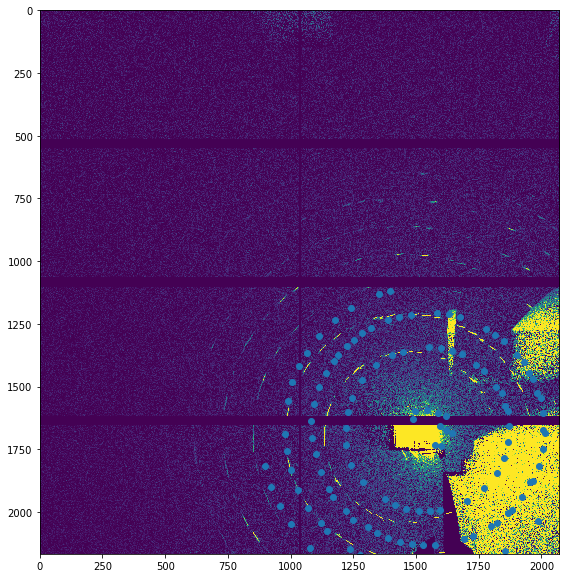

In [223]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.scatter(xs.mean(axis=1) / pixsize + b12zero[0], ys.mean(axis=1) / pixsize + b12zero[1])
plt.imshow(b12data[0], vmax=50)
# plt.xlim(1400, 2000)
# plt.ylim(1900, 1300)
plt.show()

In [247]:
%gui qt
app = makeApp()
w = VolumeViewer()
w.setData(data=volumedata(lyscrop))
w.show()

In [219]:
%gui qt
app = makeApp()
w = ScatterViewer()
w.setData(pos=lyscenters, size=20)
w.show()

# Peaks sum

In [31]:
lyssum = np.concatenate([lines for lines in lyslines if lines.any()]).mean(axis=1)
b12sum = np.concatenate([lines for lines in b12lines if lines.any()]).mean(axis=1)
lyssumints = np.concatenate([ints for ints in lysints if ints.any()])
b12sumints = np.concatenate([ints for ints in b12ints if ints.any()])

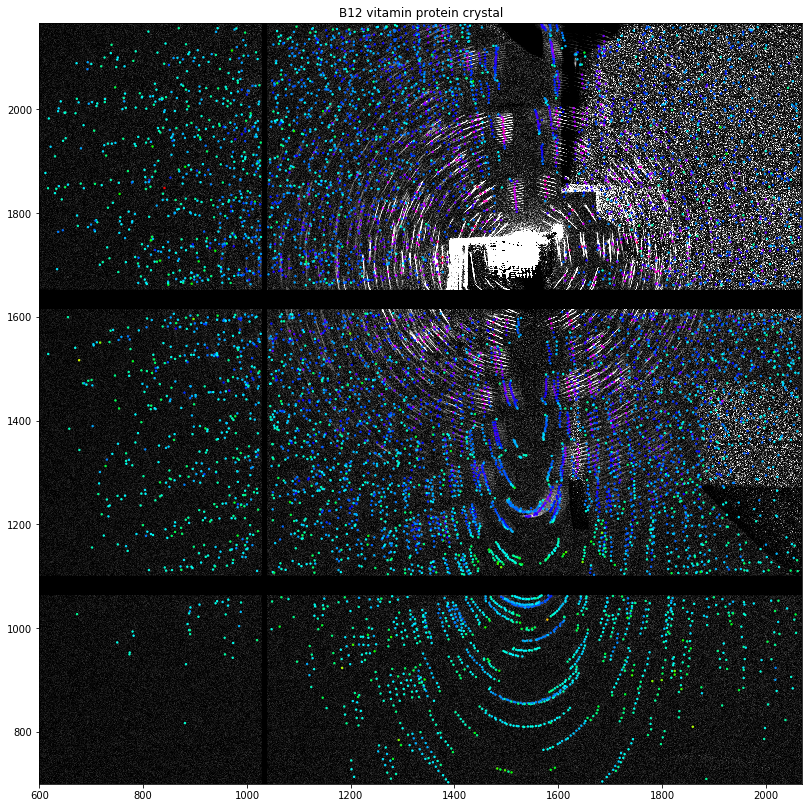

In [32]:
%matplotlib inline
plt.figure(figsize=(14, 14))
plt.imshow(b12data.sum(axis=0), vmin=0, vmax=3000, cmap='gist_gray')
plt.scatter(b12sum[:, 0], b12sum[:, 1], s=2, c=np.log(b12sumints - b12sumints.min() + 1.0), cmap='hsv')
plt.xlim((b12roi.roi[2], b12roi.roi[3]))
plt.ylim((b12roi.roi[0], b12roi.roi[1]))
plt.title('B12 vitamin protein crystal')
plt.show()

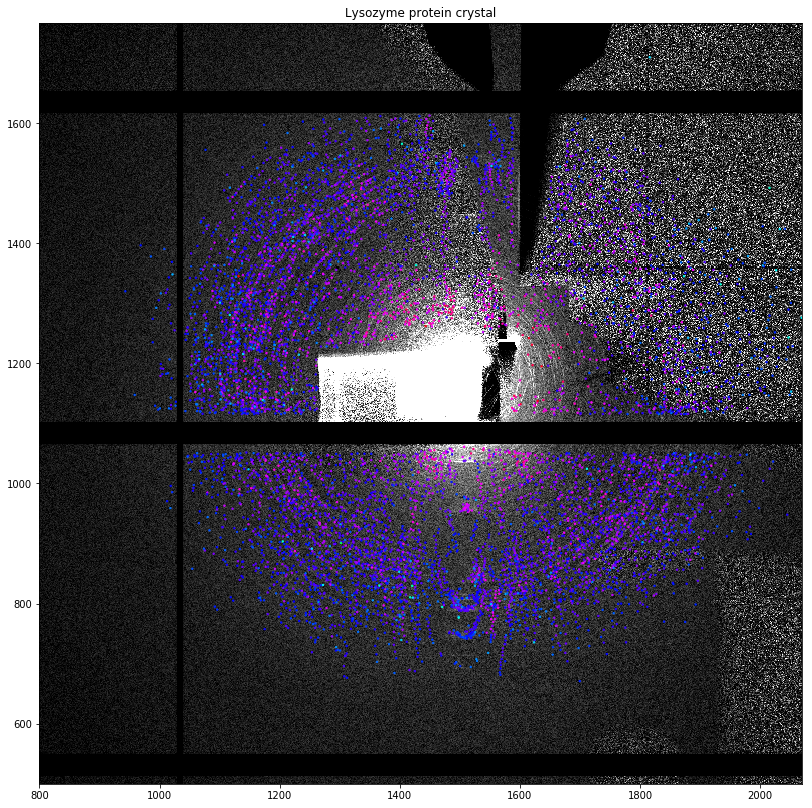

In [86]:
%matplotlib inline
plt.figure(figsize=(14, 14))
plt.imshow(lysdata.sum(axis=0), vmin=100, vmax=3000, cmap='gist_gray')
plt.scatter(lyssum[:, 0], lyssum[:, 1], s=2, c=np.log(lyssumints - lyssumints.min() + 1.0), cmap='hsv')
plt.xlim((lysroi.roi[2], lysroi.roi[3]))
plt.ylim((lysroi.roi[0], lysroi.roi[1]))
plt.title('Lysozyme protein crystal')
plt.show()

# Diffraction simulation

In [31]:
respath = 'results'
datapath = 'data/data'
zero = np.array([1000, 1000])
dd = 250
ps = 88.6e-3
wl = 1.14e-7
reslist = ['diff_06-09-2019_22-41-28.hdf5', 'diff_07-09-2019_05-32-33.hdf5']
resdata = [h5py.File(os.path.join(respath, filename), 'r')[datapath][:] for filename in reslist]
strksdata = [np.where(np.abs(res) < 0.05, 0, np.abs(res)) for res in resdata]
nmsdata = [NMS(strks) for strks in strksdata]
houghdet = HoughLineDetector(threshold=10, line_length=30, line_gap=5, dth=np.pi/1000)
lsd = LineSegmentDetector()

In [68]:
frame = np.abs(resdata[0])
strkslist = []
strkslist.append(houghdet.detectFrame(strksdata[0], zero, drtau=30, drn=10))
strkslist.append(houghdet.detectFrame(nmsdata[0], zero, drtau=30, drn=10))
strkslist.append(lsd.detectFrame(strksdata[0], zero, drtau=30, drn=10))
strkslist.append(lsd.detectFrame(nmsdata[0], zero, drtau=30, drn=10))
ptslist = [strks.indexpoints() for strks in strkslist]

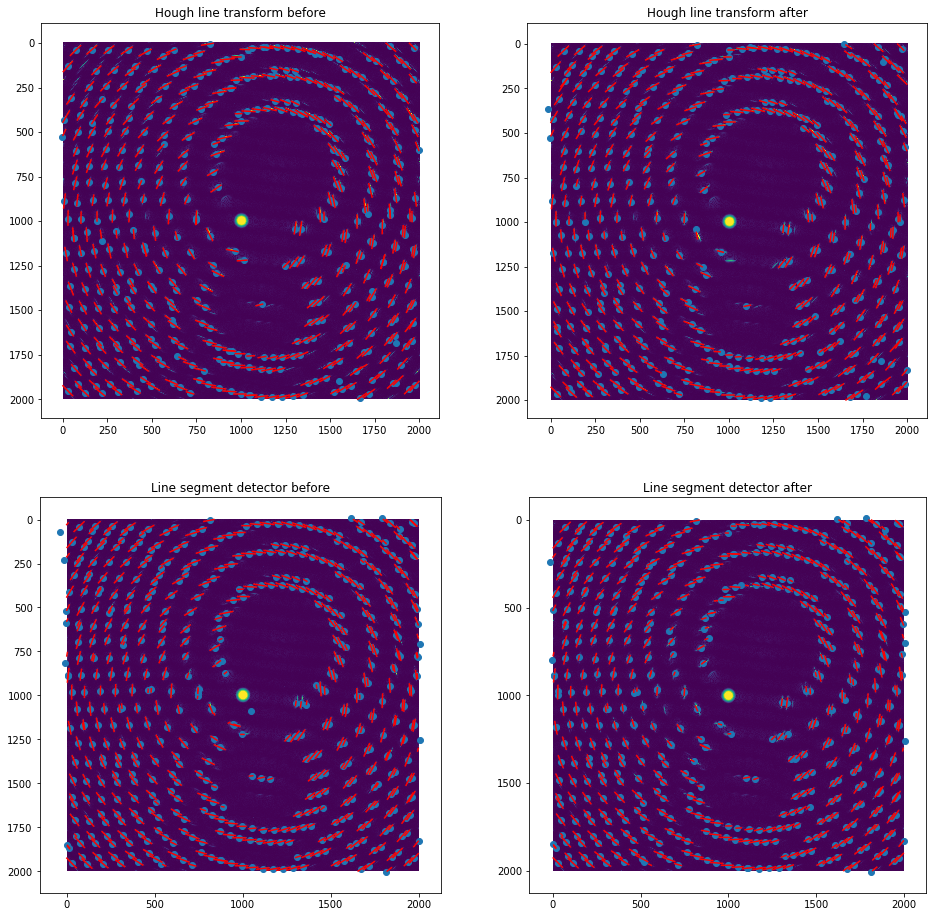

In [86]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
titles = ['Hough line transform before', 'Hough line transform after', 'Line segment detector before', 'Line segment detector after']
for ax, lines, pts, title in zip(axes.ravel(), lineslist, ptsmskd, titles):
    ax.imshow(frame, vmax=0.2)
    for line in lines:
        ax.plot(line[:, 0], line[:, 1], 'r')  
    ax.scatter(pts[:, 0], pts[:, 1])
#     ax.set_xlim(1400, 1900)
#     ax.set_ylim(1800, 1300)
    ax.set_title(title)
plt.show()

In [99]:
masklist = [(strks.radii > 50) & (np.abs(strks.xs) < 1000) & (np.abs(strks.ys) < 1000) for strks in strkslist]
medptslist = [strks.lines[mask].mean(axis=1) for strks, mask in zip(strkslist, masklist)]
ptsmskd = [pts[mask] for pts, mask in zip(ptslist, masklist)]
distlist = [np.sqrt((medpts[:, 0] - pts[:, 0])**2 + (medpts[:, 1] - pts[:, 1])**2) for medpts, pts in zip(medptslist, ptsmskd)]
distances = [np.mean(dist) for dist in distlist]
print(distances, [dist.shape[0] for dist in distlist])

[8.97665284517706, 8.456371586763451, 3.0015457716430474, 4.400921257192082] [424, 442, 513, 515]


In [240]:
class Detector(object):
    def __init__(self, detdist=54, Nx=512, Ny=512, pixsize=55e-3):
        self.detdist, self.Nx, self.Ny, self.pixsize = detdist, Nx, Ny, pixsize

    def det_coordinates(self):
        x_det = np.arange((-self.Nx + 1) / 2.0, (self.Nx + 1) / 2.0) * self.pixsize
        y_det = np.arange((-self.Ny + 1) / 2.0, (self.Ny + 1) / 2.0) * self.pixsize
        xs, ys = np.meshgrid(x_det, y_det)
        return xs, ys

    def kouts2(self):
        xs, ys = self.det_coordinates()
        kxs = np.tan(np.sqrt(xs**2 + ys**2) / self.detdist) * np.cos(np.arctan2(ys, xs))
        kys = np.tan(np.sqrt(xs**2 + ys**2) / self.detdist) * np.sin(np.arctan2(ys, xs))
        return np.stack((kxs, kys, np.sqrt(1 - kxs**2 - kys**2)), axis=2)
    
    def kouts(self):
        xs, ys = self.det_coordinates()
        return np.stack((xs / self.detdist, ys / self.detdist, 1 - (xs**2 + ys**2) / 2 / self.detdist**2), axis=2)

In [242]:
kouts = Detector(detdist, 2000, 2000, pixsize).kouts()
kouts2 = Detector(detdist, 2000, 2000, pixsize).kouts2()
idxs = lns.mean(axis=1).astype(np.int)
idxs2 = lns2.mean(axis=1).astype(np.int)
ks, ks2 = kouts[idxs[:,0], idxs[:,1]], kouts2[idxs2[:,0], idxs2[:,1]]

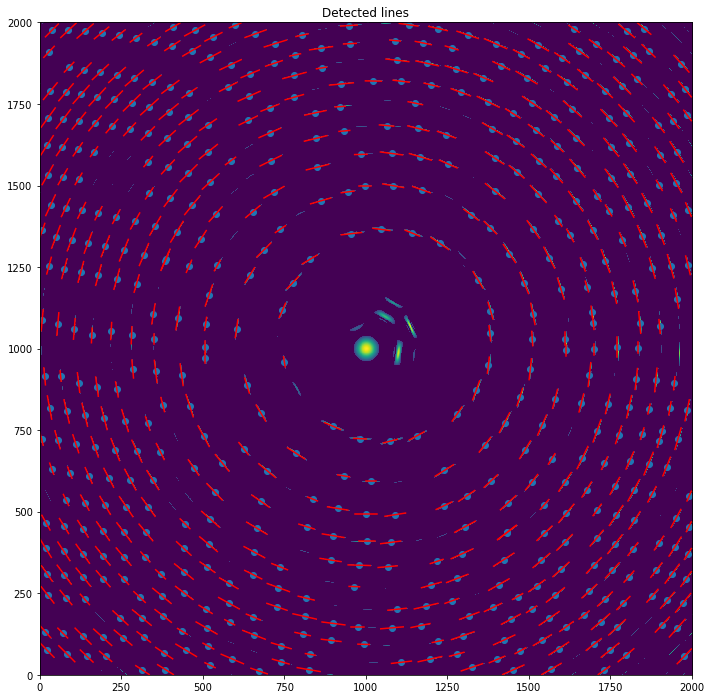

In [83]:
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.imshow(frame)
plt.scatter(lns.mean(axis=1)[:,0], lns.mean(axis=1)[:,1])
plt.title('Detected lines')
for line in lns:
    plt.plot(line[:,0], line[:,1], 'r')
plt.xlim(0, frame.shape[1])
plt.ylim(0, frame.shape[0])
plt.show()

In [32]:
arec = np.array([0.00551908483885947, -0.00294352907953398, 0.0109864094612009]) * 1e7
brec = np.array([-0.0112435046699143, 0.000431835526544485, 0.00576393741858660]) * 1e7
crec = np.array([-0.00357471961041716, -0.0255767535096894, -0.00505686021507011]) * 1e7
aa = np.cross(brec, crec) / (np.cross(brec, crec).dot(arec))
bb = np.cross(crec, arec) / (np.cross(crec, arec).dot(brec))
cc = np.cross(arec, brec) / (np.cross(arec, brec).dot(crec))
linetracer = CircPropagator(reclat=RecLattice(arec, brec, crec, qmax=0.4), NA=0.015)
xs, ys = linetracer.detectorpts(dd)

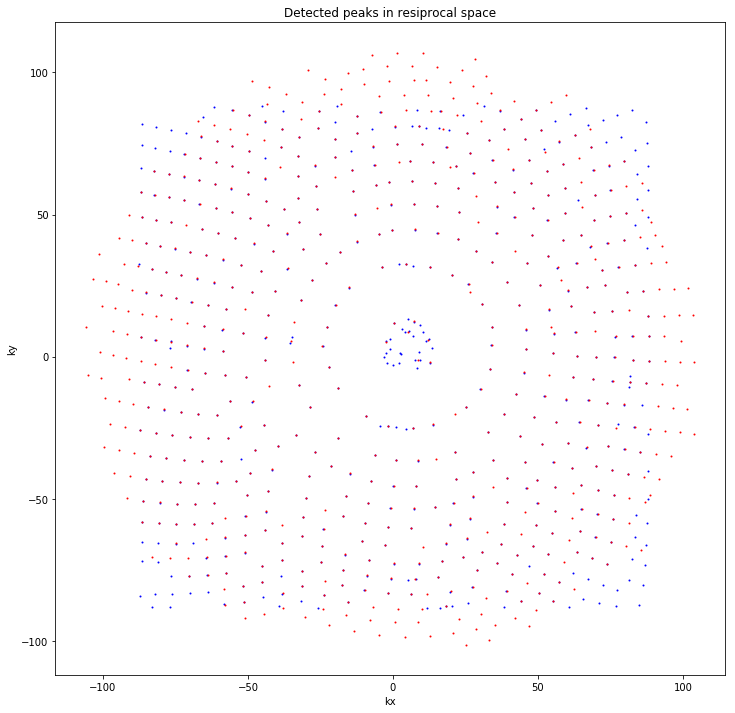

In [125]:
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.scatter(pixsize * strks.xs, pixsize * strks.ys, 1, 'b')
plt.scatter(xs.mean(axis=1), ys.mean(axis=1), 1, 'r')
plt.title('Detected peaks in resiprocal space')
plt.xlabel('kx')
plt.ylabel('ky')
plt.show()

# Indexing simulation

In [4]:
wl = 1.14e-7
dd = 250
ps = 88.6e-3
arec = np.array([0.00551908483885947, -0.00294352907953398, 0.0109864094612009]) * 1e7
brec = np.array([-0.0112435046699143, 0.000431835526544485, 0.00576393741858660]) * 1e7
crec = np.array([-0.00357471961041716, -0.0255767535096894, -0.00505686021507011]) * 1e7

In [6]:
rot_list, axis, thetas, zero = [], np.array([0, 1, 0]), np.radians(np.arange(100)), np.zeros(2)
for i, theta in enumerate(thetas):
    rotm = rotation_matrix(axis, theta)
    a, b, c = rotm.dot(arec), rotm.dot(brec), rotm.dot(crec)
    line_tracer = SquarePropagator(rec_lat=RecLattice(a, b, c, q_max=0.4, wavelength=wl), num_ap=0.01)
    xs, ys = line_tracer.detector_pts(dd)
    rot_list.append(FrameStreaks(np.stack((xs, ys), axis=2) / ps, zero))

In [8]:
sim_strks = ScanStreaks(rot_list)
qs = sim_strks.rec_vectors(-axis, thetas, ps, dd)
ref_qs = sim_strks.refined_rec_vectors(-axis, thetas, ps, dd, 30 * ps / dd)

In [9]:
size = 200
grid = qs.grid(size)
fs = np.abs(np.fft.fftshift(np.fft.fftn(grid)))**2

In [19]:
q_max, size = 0.015, 200
ref_cor = ref_qs.correlation_grid(q_max, size)

In [13]:
%gui qt
app = make_app()
w = ScatterViewer()
w.set_data(pos=ref_qs.qs, size=3)
w.show()

In [20]:
%gui qt
app = make_app()
w = VolumeViewer()
w.set_data(data=vol_data(ref_cor, alpha=0.25))
w.show()

In [17]:
%gui qt
app = make_app()
w = VolumeViewer()
w.set_data(data=vol_data(crop_cor, alpha=0.25))
w.show()

In [14]:
blur_cor = gaussian_filter(fs.astype(np.float64), size / 40)
mask = blur_cor > blur_cor.mean() + 4. * blur_cor.std()
crop_cor = np.where(mask, blur_cor, 0)
labels, num_labels = label(mask)
centers = np.array(maximum_position(blur_cor, labels=labels, index=np.arange(1, num_labels + 1))) - size / 2 * np.ones(3)

In [61]:
mask = [14, 15, 16, 11, 18, 5, 22]
mask2 = [15, 11, 5]
axes = (centers * qs.range**-1)[mask2]

In [62]:
%gui qt
app = makeApp()
w = ScatterViewer()
w.setData(pos=np.concatenate((centers[mask], np.zeros((1, 3)))), size=10)
w.show()

In [69]:
print(axes * wl, aa, bb, cc, sep='\n')

[[-5.49431325e-07 -3.59213010e-06 -6.84716043e-07]
 [-3.43394578e-06  1.79606505e-06 -6.84716043e-06]
 [-7.00524939e-06  2.76317700e-07  3.56052342e-06]]
[ 3.45318652e-06 -1.84171022e-06  6.87398766e-06]
[-7.03484725e-06  2.70191284e-07  3.60638613e-06]
[-5.16189512e-07 -3.69328321e-06 -7.30210615e-07]


In [64]:
recaxes = np.zeros(axes.shape)
recaxes[0] = np.cross(axes[1], axes[2]) / (np.cross(axes[1], axes[2]).dot(axes[0]))
recaxes[1] = np.cross(axes[2], axes[0]) / (np.cross(axes[2], axes[0]).dot(axes[1]))
recaxes[2] = np.cross(axes[0], axes[1]) / (np.cross(axes[0], axes[1]).dot(axes[2]))

In [65]:
linetracer = CircPropagator(reclat=RecLattice(recaxes[0], recaxes[2], recaxes[1], qmax=0.4, wavelength=1.), NA=0.015)
xs, ys = linetracer.detectorpts(dd)

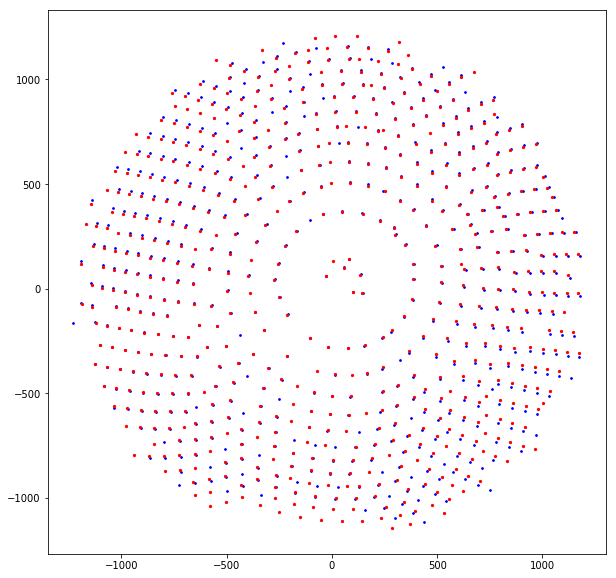

In [66]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.scatter(xs.mean(axis=1) / ps, ys.mean(axis=1) / ps, 3, 'b')
plt.scatter(rotlist[0].xs, rotlist[0].ys, 5, 'r')
plt.show()